# I. Load thư viện

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import math
import cv2
# Nhúng hình ảnh, đồ thị trong notebook
%matplotlib inline

In [2]:
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, regularizers
from keras.layers.noise import GaussianNoise
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.np_utils import to_categorical
K.set_image_dim_ordering('th')
#print(K.image_data_format())

C:\Users\vuong.huynh\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
## Sử dụng GPU
import tensorflow as tf
from keras.backend import tensorflow_backend
config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
session = tf.Session(config=config)
tensorflow_backend.set_session(session)

# II. Xử lý dữ liệu hình ảnh

## 1. Đọc dữ liệu hình ảnh

### a. Lấy hình ảnh và tên trái cây

In [4]:
folder_train = 'F:/8_Machine Learning/Bai tap Deeplearning/2_CNN/Fruit-Images-Dataset-master/Training/'
folder_test = 'F:/8_Machine Learning/Bai tap Deeplearning/2_CNN/Fruit-Images-Dataset-master/Validation/'
#folder_train = 'F:/8_Machine Learning/Bai tap Deeplearning/2_CNN/Training/'
#folder_test = 'F:/8_Machine Learning/Bai tap Deeplearning/2_CNN/Validation/'

In [5]:
def HienThiHinhAnh1(folder,Hang, Cot, figsize=(20,10)):
    sequence_folder = glob.glob(os.path.join(folder, '*/*'))
    i=1
    demImage=0
    figs = plt.figure(figsize=figsize)
    NameImage=""
    #for sq in sequence_folder[start:end][:limit]:
    for sq in sequence_folder:
        sq = sq.replace('\\', '/')
        lables = sq.split('/')[-2]
        if NameImage != lables:
            NameImage = lables
            demImage=0
        if NameImage == lables:
            demImage+1
        if demImage < Cot:
            if i<(Hang*Cot):
                img = cv2.imread(sq,cv2.COLOR_BGR2RGB)
                # Pick the first image for each label.
                plt.subplot(Hang, Cot, i)  # A grid of 8 rows x 8 columns
                #print(i)
                plt.axis('off')
                plt.title(lables, fontsize=8)
                i += 1
                _ = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [6]:
def HienThiHinhAnh(folder,Hang, Cot,NumImage, figsize=(20,10)):
    sequence_folder = glob.glob(os.path.join(folder, '*/*'))
    i=1
    demImage=0
    figs = plt.figure(figsize=figsize)
    NameImage=""
    #for sq in sequence_folder[start:end][:limit]:
    for sq in sequence_folder:
        sq = sq.replace('\\', '/')
        lables = sq.split('/')[-2]
        if NameImage != lables:
            NameImage = lables
            demImage=0
        if NameImage == lables:
            demImage+=1
        if demImage < NumImage:
            if i<(Hang*Cot):
                img = cv2.imread(sq,cv2.COLOR_BGR2RGB)
                # Pick the first image for each label.
                plt.subplot(Hang, Cot, i)  # A grid of 8 rows x 8 columns
                #print(i)
                plt.axis('off')
                plt.title(lables, fontsize=8)
                i += 1
                _ = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

#### - Hiển thị ảnh sử dụng để Training

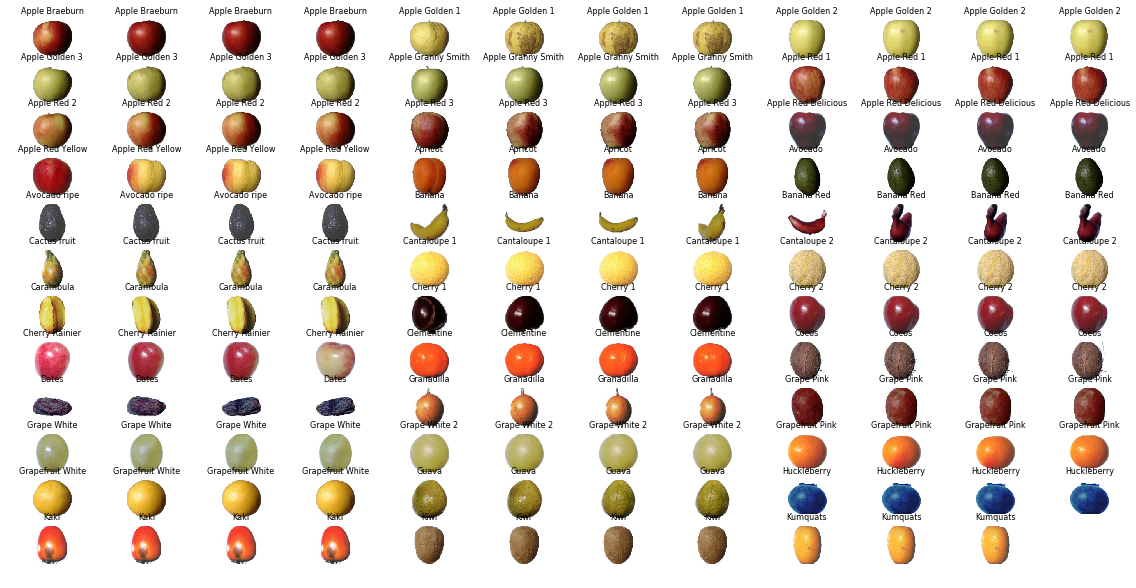

In [7]:
HienThiHinhAnh(folder_train,12,12,5)

- Mỗi loại trái cây khác nhau:
    + Có loại có hình dạng và màu sắc giống nhau ==> Rất khó phân biệt
    + Có loại có hình dạng và màu sắc khác nhau ==> Dễ phân biệt
- Trong cùng loại trái:
    + Hình dạng khác nhau
    + Màu sắc khác nhau
    + Kích thước trái khắc nhau

#### - Hiển thị ảnh sử dụng để Test 

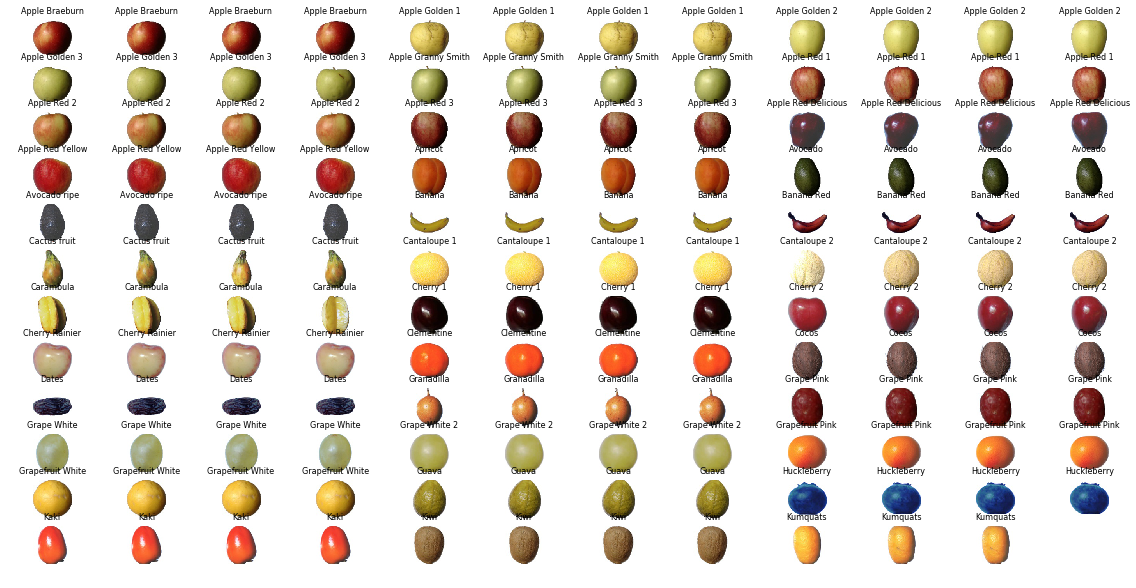

In [8]:
HienThiHinhAnh(folder_test,12,12,5)

In [14]:
image_size = 64

In [15]:
def get_im(path):
    #Đọc dữ liệu ảnh màu sử dụng thư viện opencv
    #Hàm imread chuyển đổi hình ảnh sang mảng
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    #img = cv2.imread(path, cv2.COLOR_BGR2RGB)
    # resize ảnh về cùng kích thước
    resized = cv2.resize(img, (image_size, image_size))
    return resized

In [11]:
def load_sequence1(folder):
    sequence_folder = glob.glob(os.path.join(folder, '*/*'))
    X = []
    TenTraiCay = []
    for sq in sequence_folder:
        #print(sq.replace('\\', '/'))
        sq = sq.replace('\\', '/')
        lables = sq.split('/')[-2]
        img = get_im(sq)
        #img = img_to_array(img)
        X.append(img)
        TenTraiCay.append(lables)
    return np.array(X, dtype=np.uint8), np.asarray(TenTraiCay)

In [12]:
def load_sequence2(folder):
    sequence_folder = glob.glob(os.path.join(folder, '*/*'))
    X = []
    TenTraiCay = []
    for sq in sequence_folder:
        #print(sq.replace('\\', '/'))
        sq = sq.replace('\\', '/')
        lables = sq.split('/')[-2]
        img = get_im(sq)
        img = img_to_array(img)
        X.append(img)
        TenTraiCay.append(lables)
        dataX = np.array(X, dtype=np.uint8)
    return np.array(dataX, dtype="float") / 255.0, np.asarray(TenTraiCay)

In [26]:
def load_sequence(folder):
    sequence_folder = glob.glob(os.path.join(folder, '*/*'))
    X = []
    TenTraiCay = []
    for sq in sequence_folder:
        #print(sq.replace('\\', '/'))
        sq = sq.replace('\\', '/')
        lables = sq.split('/')[-2]
        img = get_im(sq)
        img = img_to_array(img)
        X.append(img)
        TenTraiCay.append(lables)
    return np.array(X, dtype=np.uint8), np.asarray(TenTraiCay)

In [13]:
x_train,y_train=load_sequence2(folder_train)
x_test,y_test=load_sequence2(folder_test)
print (x_train.shape)
print (x_test.shape)

(35133, 3, 64, 64)
(11804, 3, 64, 64)


In [14]:
d='F:/8_Machine Learning/Bai tap Deeplearning/2_CNN/Train'
np.save(d,x_train)

In [15]:
d1='F:/8_Machine Learning/Bai tap Deeplearning/2_CNN/Train_lables'
np.save(d1,y_train)

In [16]:
#np.load("F:\8_Machine Learning\Bai tap Deeplearning\2_CNN\Train.csv")

In [17]:
d2='F:/8_Machine Learning/Bai tap Deeplearning/2_CNN/Test'
np.save(d2,x_test)

In [18]:
d3='F:/8_Machine Learning/Bai tap Deeplearning/2_CNN/Test_labels'
np.save(d3,y_test)

In [5]:
x_train = np.load('F:/8_Machine Learning/Bai tap Deeplearning/2_CNN/DATA 64X64/Train.npy')
y_train = np.load('F:/8_Machine Learning/Bai tap Deeplearning/2_CNN/DATA 64X64/Train_lables.npy')

In [6]:
x_test = np.load('F:/8_Machine Learning/Bai tap Deeplearning/2_CNN/DATA 64X64/Test.npy')
y_test = np.load('F:/8_Machine Learning/Bai tap Deeplearning/2_CNN/DATA 64X64/Test_labels.npy')

In [7]:
TenTraiCay_Training = y_train

In [8]:
num_classes = len(set(y_train))
print("Số trái cây cần phân loại: {0} ".format(len(set(y_train))))

Số trái cây cần phân loại: 70 


### b.cale dữ liệu hình ảnh (pixel) train và test về dạng [0,1]

In [ ]:
x_train = np.array(x_train, dtype="float") / 255.0
x_test = np.array(x_test, dtype="float") / 255.0

### c. Chuyển đổi nhãn (Tên trái cây) sang mãng cho tập Train và Test

In [9]:
y_train = np.array(y_train)
y_test = np.array(y_test)

### d. Chuyển đổi label sang số

In [10]:
from sklearn.preprocessing import LabelEncoder
labelencoder_X=LabelEncoder()
y_train = labelencoder_X.fit_transform(y_train)
y_test=labelencoder_X.transform(y_test)
#print (y_train)

### e. Chuyển đổi dữ liệu vector (int từ 0 đến 79) về ma trận lớp nhị phân (one-hot encoding)

In [11]:
# Cách 1 sử dụng keras
from keras import utils as np_utils
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
#y_train

In [12]:
# Cách 2 sử dụng sklearn
#from sklearn.preprocessing import LabelBinarizer
#encoder = LabelBinarizer()
#y_train = encoder.fit_transform(y_train)
#y_test = encoder.fit_transform(y_test)

# III. Training mạng CNN 

## 1.  Thiết lập mạng

### a. Khai báo biến đầu vào cho mạng CNN 

#### - Khai báo kích thước ảnh 

In [16]:
# Size ảnh
img_rows, img_cols = image_size, image_size
# Khai báo ảnh màu
input_shape = (3,img_rows, img_cols)

In [17]:
# batch_size: Do bộ nhớ của máy tính / card đồ họa có giới hạn nên chúng ta không thể học tất cả dữ liệu một lúc. 
# Mà chúng ta sẽ sử dụng từng bộ dữ liệu nhỏ để tính theo nhiều lần. Số lượng dữ liệu một lần tính gọi là batch_size
batch_size = 64
# epochs là số lần học
epoch = 20
# Kích thước hàm filter
filter_pixel=3
# Dropout là một kĩ thuật Regularization để chống lại vấn đề overfitting
# https://labs.septeni-technology.jp/technote/ml-17-neural-net-regularization-with-drop-out/
droprate=0.25

### b. Khai báo mạng CNN 

In [18]:
# Giải thích chức năng từng hàm trong mạng CNN https://thorpham.github.io/blog/2018/05/25/keras/
# https://deeplearning.vn/2018/01/10/nhan-dien-chu-viet-bang-keras-phan-1/

In [19]:
#Chúng ta khởi tạo model bằng Sequential sau đó dùng method add để thêm các layer.
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(droprate))
 
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(droprate))
 
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(droprate))
 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(droprate))
model.add(Dense(70, activation='softmax'))

In [20]:
# Hàm compile : Sau khi build model xong thì compile nó có tác dụng biên tập lại toàn bộ model của chúng ta đã build. 
# Ở đây chúng ta có thể chọn các tham số để training model như : 
    #thuật toán training thông qua tham số optimizer, 
    #function loss của model chúng ta có thể sử dụng mặc định hoặc tự build thông qua tham số loss.
    #chọn metrics hiện thị khi model được training

In [21]:
from keras import layers, models, optimizers, metrics, losses

In [31]:
model1 = model

In [32]:
#optimizers.RMSprop(): RMSprop là một trong những thuật toán để cập nhật trọng số của mạng sau khi tính được độ lỗi loss
#metrics.categorical_accuracy: Do đặc thù bài toán này là đầu ra sẽ có 70 giá trị ứng với 70 lớp (class) của dữ liệu và chúng ta đã chọn hàm kích hoạt là “softmax”
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model1.compile(optimizer=optimizers.RMSprop(), loss=losses.categorical_crossentropy,metrics=[metrics.categorical_accuracy])

Chức năng complile này sẽ có tác dụng điều chỉnh mạng tại chỗ chứ không tạo ra một object mới.
    - optimizer: cơ chế mà mạng network sử dụng để tối ưu hóa hàm loss.
    - loss: là hàm loss function. Đây chính là chỉ số để feedback lại cho learning weight điều chỉnh lại sau mỗi vòng lặp nhằm đi đến giá trị minimum.
    - metrics: yếu tố đánh giá độ chính xác model

In [33]:
# summary 
    # Tổng hợp lại model xem model có bao nhiêu layer
    # Tổng số tham số bao nhiêu
    # shape của mỗi layer

In [34]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 64, 64)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 62, 62)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 31, 31)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 31, 31)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 31, 31)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 29, 29)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 14, 14)        0         
__________

#### - Huấn luyện mô hình 

In [35]:
#fit
# dùng để đưa data vào training để tìm tham số model

In [36]:
MoHinhTrain1 = model1.fit(x_train, y_train, batch_size=batch_size, epochs=epoch, verbose=1, validation_data=(x_test, y_test))

Train on 35133 samples, validate on 11804 samples
Epoch 1/20
35133/35133 [==============================] - 46s 1ms/step - loss: 1.5783 - categorical_accuracy: 0.5589 - val_loss: 0.3903 - val_categorical_accuracy: 0.8866
Epoch 2/20
35133/35133 [==============================] - 34s 970us/step - loss: 0.2429 - categorical_accuracy: 0.9229 - val_loss: 0.2519 - val_categorical_accuracy: 0.9263
Epoch 3/20
35133/35133 [==============================] - 35s 994us/step - loss: 0.1186 - categorical_accuracy: 0.9623 - val_loss: 0.2855 - val_categorical_accuracy: 0.9339
Epoch 4/20
35133/35133 [==============================] - 34s 969us/step - loss: 0.0877 - categorical_accuracy: 0.9731 - val_loss: 1.1179 - val_categorical_accuracy: 0.8104
Epoch 5/20
35133/35133 [==============================] - 34s 975us/step - loss: 0.0735 - categorical_accuracy: 0.9760 - val_loss: 0.1693 - val_categorical_accuracy: 0.9467
Epoch 6/20
35133/35133 [==============================] - 34s 963us/step - loss: 0.0622

In [37]:
#history dùng để xem accuracy,loss qua từng epochs . Thường dùng với matplotlib để vẽ chart.

In [38]:
#Epoch số lần học 20
#loss: 0.0808: Đây là độ lỗi trên tập train trong epoch này
#categorical_accuracy: 0.9858: Đây là độ chính xác trên tập train. Đây có nghĩa là mạng đã đạt được 98.58% trên tập train.
#val_loss: 0.4357 : Đây là độ lỗi trên tập test trong epoch này.
#val_categorical_accuracy: 0.9555: Đây là độ chính xác trên tập test. Đây có nghĩa là mạng đã đạt được 95.55% trên tập test.

#### - Đánh giá mô hình 

In [39]:
#evaluate
#để tính toán độ chính xác của model

In [40]:
MoHinh1 = model1.evaluate(x_test, y_test)
MoHinh1

11804/11804 [==============================] - 5s 419us/step


[0.4356781585803393, 0.9555235513385293]

#### - Vẽ đồ thị  giá trị lỗi giữa tập Train và Test

In [41]:
def DoThiTiLeLoi(MoHinhSauTrain):
    history_dict = MoHinhSauTrain.history
    train_acc = history_dict['categorical_accuracy']
    train_loss = history_dict['loss']
  
    val_acc = history_dict['val_categorical_accuracy']
    val_loss = history_dict['val_loss']
  
    epochs = range(1, len(train_acc) + 1)
  
    plt.plot(epochs, train_loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

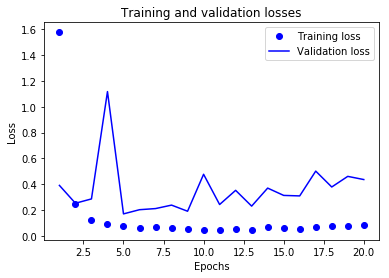

In [42]:
DoThiTiLeLoi(MoHinhTrain1)

- Dựa vào đồ thị ta thấy Training nhiều lần làm cho tỉ lỗi của tập test lớn.
- Chỉ cần Epochs 5 lần là đủ


### c. Dự đoán kết quả sau traing (Predict) 

####  - Chuyển đổi ảnh để Predict

In [43]:
def ImagePredict(path):
    dataPre=[]
    #imgPre = cv2.imread(path,cv2.IMREAD_ANYCOLOR)
    imgPre =get_im(path)
    imgPre = img_to_array(imgPre)
    dataPre.append(imgPre)
    dataPredict=np.array(dataPre, dtype=np.uint8)
    dataPredict = np.array(dataPredict, dtype="float") / 255.0
    return dataPredict

#### - Predict ảnh 

In [44]:
#Để tìm chỉ số mà tại đó mảng một chiều đạt giá trị nhỏ nhất hay lớn nhất

In [45]:
diachiImage='F:/8_Machine Learning/Bai tap Deeplearning/2_CNN/Fruit-Images-Dataset-master/Training/Apple Golden 1/0_100.jpg'
#KetQuaDuDoan = model.predict(ImagePredict(diachiImage))
max_index = np.argmax(model.predict(ImagePredict(diachiImage)))
max_index

1

In [46]:
def TenTraiCayPredict(LablesName, ViTri):
    return LablesName[ViTri]

In [47]:
TenTraiCayPredict(TenTraiCay_Training,max_index)

'Apple Braeburn'

#### - Hiển thị kết quả dự đoán 

In [50]:
def HienThiKetQuaDuDoan(MoHinh,folder,Hang, Cot,NumImage, figsize=(20,10)):
    sequence_folder = glob.glob(os.path.join(folder, '*/*'))
    i=1
    demImage=0
    figs = plt.figure(figsize=figsize)
    NameImage=""
    #for sq in sequence_folder[start:end][:limit]:
    for sq in sequence_folder:
        sq = sq.replace('\\', '/')
        lables = sq.split('/')[-2]
        if NameImage != lables:
            NameImage = lables
            demImage=0
        if NameImage == lables:
            demImage+=1
        if demImage < NumImage:
            if i<(Hang*Cot):
                img = cv2.imread(sq,cv2.COLOR_BGR2RGB)
                
                ResultPr = MoHinh.predict(ImagePredict(sq))
                max_indexImage = np.argmax(ResultPr[0])
                LabelPred = TenTraiCayPredict(TenTraiCay_Training,max_indexImage)
                # Pick the first image for each label.
                plt.subplot(Hang, Cot, i)  # A grid of 8 rows x 8 columns
                #print(i)
                plt.axis('off')
                plt.title(lables+":"+LabelPred, fontsize=8)
                i += 1
                _ = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

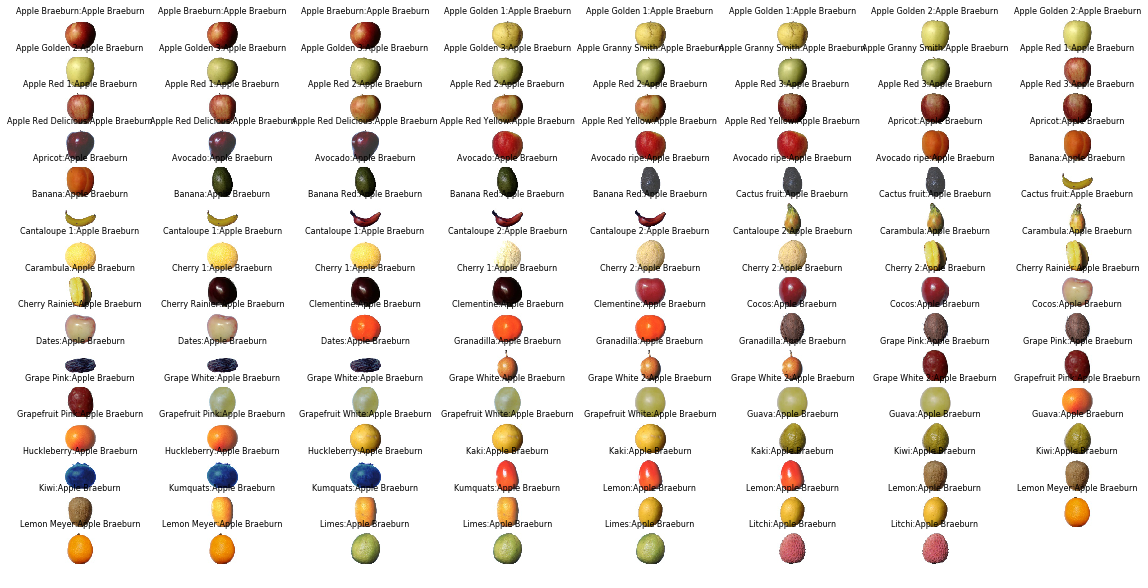

In [52]:
HienThiKetQuaDuDoan(model,folder_test,15,8,4)

In [86]:
d=[]
img1 = cv2.imread('F:/8_Machine Learning/Bai tap Deeplearning/2_CNN/Fruit-Images-Dataset-master/Training/Apple Golden 1/0_100.jpg',cv2.IMREAD_ANYCOLOR)
img1 = img_to_array(img1)
d.append(img1)
data=np.array(d, dtype=np.uint8)

data = np.array(data, dtype="float") / 255.0
model.predict(data)

array([[1.50195287e-08, 9.99989986e-01, 1.78310557e-07, 4.41750899e-06,
        2.83847783e-07, 5.11708187e-09, 1.32473579e-08, 2.71927925e-09,
        7.26497747e-13, 4.66270966e-10, 1.47919756e-08, 1.29302846e-13,
        3.39469636e-13, 5.35784750e-10, 8.00282118e-10, 3.79887899e-09,
        8.46108037e-07, 4.59520848e-08, 4.64779014e-11, 6.05488770e-09,
        1.17193406e-06, 5.98152153e-11, 2.36637746e-07, 6.88344493e-10,
        3.31566302e-11, 7.24051374e-11, 4.00088556e-12, 3.10146214e-11,
        5.88830940e-09, 7.80611984e-08, 2.49756408e-06, 1.42482623e-10,
        1.33614153e-09, 1.05776343e-13, 2.32561886e-11, 1.66577241e-09,
        1.59835012e-09, 9.78261170e-08, 1.49580826e-09, 8.50310684e-08,
        1.60111533e-08, 1.22170912e-10, 3.74965226e-10, 5.84989626e-11,
        5.47906789e-11, 3.04269318e-11, 1.73423831e-09, 2.59690686e-10,
        5.42023870e-10, 4.57114924e-09, 1.41401044e-10, 1.99963335e-08,
        2.17377472e-09, 1.87235227e-10, 4.20664437e-09, 1.016848

In [87]:
import numpy
max_index = numpy.argmax(model.predict(data))

In [ ]:
def TenTraiCayPredict(LablesName, ViTri):
    return LablesName[ViTri]

In [88]:
TenTraiCayPredict(TenTraiCay_Training,max_index)

1

# IV. Tuning mạng CNN 

## 1. Thay đổi mô hình học 

In [53]:
model2 = model

In [54]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model2.compile(optimizer=sgd, loss=losses.mean_squared_error,metrics=[metrics.categorical_accuracy])

In [55]:
MoHinhTrain2 = model2.fit(x_train, y_train, batch_size=batch_size, epochs=epoch, verbose=1, validation_data=(x_test, y_test))

Train on 35133 samples, validate on 11804 samples
Epoch 1/20
35133/35133 [==============================] - 39s 1ms/step - loss: 1.8825e-04 - categorical_accuracy: 0.9906 - val_loss: 9.7795e-04 - val_categorical_accuracy: 0.9636
Epoch 2/20
35133/35133 [==============================] - 35s 983us/step - loss: 1.7061e-04 - categorical_accuracy: 0.9913 - val_loss: 9.5842e-04 - val_categorical_accuracy: 0.9637
Epoch 3/20
35133/35133 [==============================] - 34s 967us/step - loss: 1.6462e-04 - categorical_accuracy: 0.9914 - val_loss: 8.9511e-04 - val_categorical_accuracy: 0.9660
Epoch 4/20
35133/35133 [==============================] - 34s 977us/step - loss: 1.4924e-04 - categorical_accuracy: 0.9923 - val_loss: 8.7412e-04 - val_categorical_accuracy: 0.9668
Epoch 5/20
35133/35133 [==============================] - 35s 999us/step - loss: 1.6092e-04 - categorical_accuracy: 0.9912 - val_loss: 8.7457e-04 - val_categorical_accuracy: 0.9667
Epoch 6/20
35133/35133 [=======================

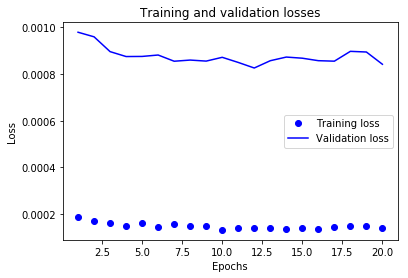

In [56]:
DoThiTiLeLoi(MoHinhTrain2)

In [ ]:
#Đối với mô hình SGD ta thấy chỉ cần training 12 lần là cho kết quả tốt nhất
# Độ chính xác trên tập Train: 99.2% và Test: 96.87

In [57]:
model3 = model
Adag = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.9)
model3.compile(optimizer=Adag, loss=losses.mean_squared_error,metrics=[metrics.categorical_accuracy])
MoHinhTrain3 = model3.fit(x_train, y_train, batch_size=batch_size, epochs=epoch, verbose=1, validation_data=(x_test, y_test))

Train on 35133 samples, validate on 11804 samples
Epoch 1/20
35133/35133 [==============================] - 39s 1ms/step - loss: 6.7996e-04 - categorical_accuracy: 0.9751 - val_loss: 0.0016 - val_categorical_accuracy: 0.9407
Epoch 2/20
35133/35133 [==============================] - 36s 1ms/step - loss: 5.2872e-04 - categorical_accuracy: 0.9808 - val_loss: 0.0016 - val_categorical_accuracy: 0.9422
Epoch 3/20
35133/35133 [==============================] - 35s 999us/step - loss: 5.4292e-04 - categorical_accuracy: 0.9800 - val_loss: 0.0016 - val_categorical_accuracy: 0.9426
Epoch 4/20
35133/35133 [==============================] - 37s 1ms/step - loss: 5.2463e-04 - categorical_accuracy: 0.9808 - val_loss: 0.0016 - val_categorical_accuracy: 0.9427
Epoch 5/20
35133/35133 [==============================] - 36s 1ms/step - loss: 5.1194e-04 - categorical_accuracy: 0.9812 - val_loss: 0.0016 - val_categorical_accuracy: 0.9428
Epoch 6/20
35133/35133 [==============================] - 35s 999us/step 

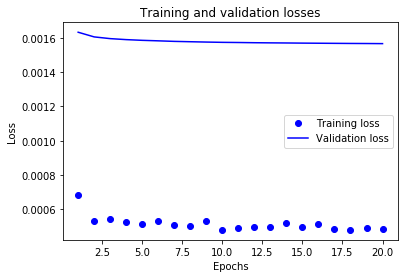

In [58]:
DoThiTiLeLoi(MoHinhTrain3)

In [59]:
model4 = model
Adad = optimizers.Adadelta(lr=0.01, rho=0.95, epsilon=None, decay=0.9)
model4.compile(optimizer=Adad, loss=losses.mean_squared_error,metrics=[metrics.categorical_accuracy])
MoHinhTrain4 = model4.fit(x_train, y_train, batch_size=batch_size, epochs=epoch, verbose=1, validation_data=(x_test, y_test))

Train on 35133 samples, validate on 11804 samples
Epoch 1/20
35133/35133 [==============================] - 40s 1ms/step - loss: 4.8692e-04 - categorical_accuracy: 0.9822 - val_loss: 0.0016 - val_categorical_accuracy: 0.9437
Epoch 2/20
35133/35133 [==============================] - 36s 1ms/step - loss: 4.8365e-04 - categorical_accuracy: 0.9821 - val_loss: 0.0016 - val_categorical_accuracy: 0.9437
Epoch 3/20
35133/35133 [==============================] - 36s 1ms/step - loss: 4.6156e-04 - categorical_accuracy: 0.9829 - val_loss: 0.0016 - val_categorical_accuracy: 0.9437
Epoch 4/20
35133/35133 [==============================] - 34s 977us/step - loss: 4.8831e-04 - categorical_accuracy: 0.9818 - val_loss: 0.0016 - val_categorical_accuracy: 0.9437
Epoch 5/20
35133/35133 [==============================] - 36s 1ms/step - loss: 4.7173e-04 - categorical_accuracy: 0.9825 - val_loss: 0.0016 - val_categorical_accuracy: 0.9437
Epoch 6/20
35133/35133 [==============================] - 35s 1ms/step - 

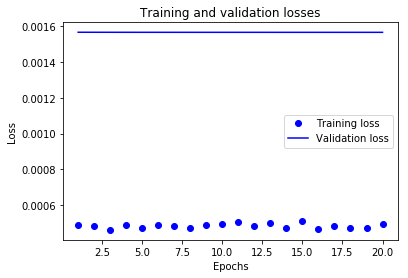

In [60]:
DoThiTiLeLoi(MoHinhTrain4)

In [61]:
model5 = model
adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.9, amsgrad=False)
model5.compile(optimizer=adam, loss=losses.mean_squared_error,metrics=[metrics.categorical_accuracy])
MoHinhTrain5 = model5.fit(x_train, y_train, batch_size=batch_size, epochs=epoch, verbose=1, validation_data=(x_test, y_test))

Train on 35133 samples, validate on 11804 samples
Epoch 1/20
35133/35133 [==============================] - 38s 1ms/step - loss: 2.5760e-04 - categorical_accuracy: 0.9896 - val_loss: 0.0010 - val_categorical_accuracy: 0.9637
Epoch 2/20
35133/35133 [==============================] - 35s 1ms/step - loss: 1.8453e-04 - categorical_accuracy: 0.9921 - val_loss: 0.0010 - val_categorical_accuracy: 0.9634
Epoch 3/20
35133/35133 [==============================] - 35s 1ms/step - loss: 1.6480e-04 - categorical_accuracy: 0.9925 - val_loss: 9.8749e-04 - val_categorical_accuracy: 0.9639
Epoch 4/20
35133/35133 [==============================] - 35s 1ms/step - loss: 1.6317e-04 - categorical_accuracy: 0.9929 - val_loss: 9.5470e-04 - val_categorical_accuracy: 0.9652
Epoch 5/20
35133/35133 [==============================] - 35s 994us/step - loss: 1.7186e-04 - categorical_accuracy: 0.9924 - val_loss: 9.3466e-04 - val_categorical_accuracy: 0.9660
Epoch 6/20
35133/35133 [==============================] - 35s

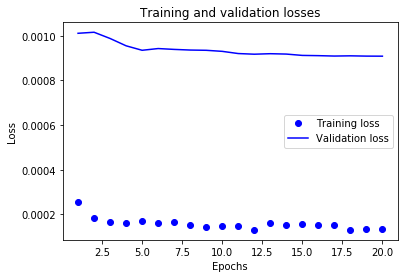

In [62]:
DoThiTiLeLoi(MoHinhTrain5)

In [28]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [32]:
def create_model():
    modelN = Sequential()
    modelN.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    modelN.add(Conv2D(32, (3, 3), activation='relu'))
    modelN.add(MaxPooling2D(pool_size=(2, 2)))
    modelN.add(Dropout(droprate))
 
    modelN.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    modelN.add(Conv2D(64, (3, 3), activation='relu'))
    modelN.add(MaxPooling2D(pool_size=(2, 2)))
    modelN.add(Dropout(droprate))
 
    modelN.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    modelN.add(Conv2D(64, (3, 3), activation='relu'))
    modelN.add(MaxPooling2D(pool_size=(2, 2)))
    modelN.add(Dropout(droprate))
 
    modelN.add(Flatten())
    modelN.add(Dense(128, activation='relu'))
    modelN.add(Dropout(droprate))
    modelN.add(Dense(70, activation='softmax'))
    #modelN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    modelN.compile(optimizer=optimizers.RMSprop(), loss=losses.categorical_crossentropy,metrics=[metrics.categorical_accuracy])
    return modelN

In [33]:
#modelSelectOptimizer = model
modelSelectOptimizer = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=0)
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=modelSelectOptimizer, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(x_train, y_train)


#classifier = KerasClassifier(build_fn=modelSelectOptimizer)

#parameters = {'batch_size': [25,32],
              #'epochs': [5,10],
              #'optimizer': ['adam', 'rmsprop'],
             #}
#grid_search = GridSearchCV(estimator=modelSelectOptimizer,param_grid = parameters,scoring = 'accuracy',cv = 10)
#grid_search = grid_search.fit(x_train, y_train)
#Adad = optimizers.Adadelta(lr=0.01, rho=0.95, epsilon=None, decay=0.9)
#model4.compile(optimizer=Adad, loss=losses.mean_squared_error,metrics=[metrics.categorical_accuracy])
#MoHinhTrain4 = model4.fit(x_train, y_train, batch_size=batch_size, epochs=epoch, verbose=1, validation_data=(x_test, y_test))




OSError: [Errno 28] No space left on device

## 2. Thay đổi mạng CNN

### a. Thay đổi hàm sofmax sang sigmoid 

In [63]:
modelSig = Sequential()
modelSig.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
modelSig.add(Conv2D(32, (3, 3), activation='relu'))
modelSig.add(MaxPooling2D(pool_size=(2, 2)))
modelSig.add(Dropout(droprate))
 
modelSig.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
modelSig.add(Conv2D(64, (3, 3), activation='relu'))
modelSig.add(MaxPooling2D(pool_size=(2, 2)))
modelSig.add(Dropout(droprate))
 
modelSig.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
modelSig.add(Conv2D(64, (3, 3), activation='relu'))
modelSig.add(MaxPooling2D(pool_size=(2, 2)))
modelSig.add(Dropout(droprate))
 
modelSig.add(Flatten())
modelSig.add(Dense(128, activation='relu'))
modelSig.add(Dropout(droprate))
modelSig.add(Dense(70, activation='sigmoid'))

In [64]:
modelSig1 = modelSig
modelSig1.compile(optimizer=optimizers.RMSprop(), loss=losses.categorical_crossentropy,metrics=[metrics.categorical_accuracy])

In [65]:
MoHinhTrainSig1 = modelSig1.fit(x_train, y_train, batch_size=batch_size, epochs=epoch, verbose=1, validation_data=(x_test, y_test))

Train on 35133 samples, validate on 11804 samples
Epoch 1/20
35133/35133 [==============================] - 40s 1ms/step - loss: 1.7625 - categorical_accuracy: 0.5080 - val_loss: 0.4599 - val_categorical_accuracy: 0.8517
Epoch 2/20
35133/35133 [==============================] - 35s 1ms/step - loss: 0.2725 - categorical_accuracy: 0.9163 - val_loss: 0.2210 - val_categorical_accuracy: 0.9397
Epoch 3/20
35133/35133 [==============================] - 35s 1ms/step - loss: 0.1332 - categorical_accuracy: 0.9594 - val_loss: 0.1464 - val_categorical_accuracy: 0.9532
Epoch 4/20
35133/35133 [==============================] - 37s 1ms/step - loss: 0.0937 - categorical_accuracy: 0.9697 - val_loss: 0.1947 - val_categorical_accuracy: 0.9472
Epoch 5/20
35133/35133 [==============================] - 35s 983us/step - loss: 0.0721 - categorical_accuracy: 0.9764 - val_loss: 0.3370 - val_categorical_accuracy: 0.9332
Epoch 6/20
35133/35133 [==============================] - 35s 1ms/step - loss: 0.0652 - categ

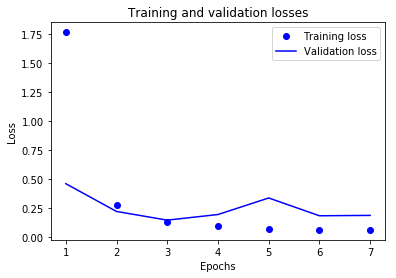

In [66]:
DoThiTiLeLoi(MoHinhTrainSig1)

In [67]:
modelSig2 = modelSig
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
modelSig2.compile(optimizer=sgd, loss=losses.mean_squared_error,metrics=[metrics.categorical_accuracy])
MoHinhTrainSig2 = modelSig2.fit(x_train, y_train, batch_size=batch_size, epochs=epoch, verbose=1, validation_data=(x_test, y_test))

Train on 35133 samples, validate on 11804 samples
Epoch 1/20
35133/35133 [==============================] - 38s 1ms/step - loss: nan - categorical_accuracy: 0.0140 - val_loss: nan - val_categorical_accuracy: 0.0139
Epoch 2/20
35133/35133 [==============================] - 34s 981us/step - loss: nan - categorical_accuracy: 0.0140 - val_loss: nan - val_categorical_accuracy: 0.0139
Epoch 3/20
35133/35133 [==============================] - 34s 979us/step - loss: nan - categorical_accuracy: 0.0140 - val_loss: nan - val_categorical_accuracy: 0.0139
Epoch 4/20
35133/35133 [==============================] - 35s 989us/step - loss: nan - categorical_accuracy: 0.0140 - val_loss: nan - val_categorical_accuracy: 0.0139
Epoch 5/20
35133/35133 [==============================] - 35s 986us/step - loss: nan - categorical_accuracy: 0.0140 - val_loss: nan - val_categorical_accuracy: 0.0139
Epoch 6/20
35133/35133 [==============================] - 35s 990us/step - loss: nan - categorical_accuracy: 0.0140 -

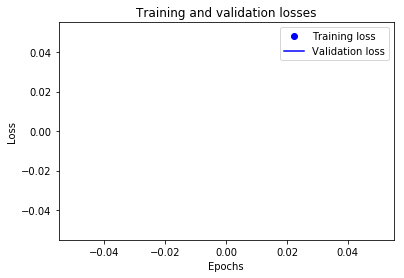

In [68]:
DoThiTiLeLoi(MoHinhTrainSig2)

In [69]:
modelSig3 = modelSig
Adag = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.9)
modelSig3.compile(optimizer=Adag, loss=losses.mean_squared_error,metrics=[metrics.categorical_accuracy])
MoHinhTrainSig3 = modelSig3.fit(x_train, y_train, batch_size=batch_size, epochs=epoch, verbose=1, validation_data=(x_test, y_test))

Train on 35133 samples, validate on 11804 samples
Epoch 1/20
35133/35133 [==============================] - 36s 1ms/step - loss: nan - categorical_accuracy: 0.0140 - val_loss: nan - val_categorical_accuracy: 0.0139
Epoch 2/20
35133/35133 [==============================] - 34s 965us/step - loss: nan - categorical_accuracy: 0.0140 - val_loss: nan - val_categorical_accuracy: 0.0139
Epoch 3/20
35133/35133 [==============================] - 34s 981us/step - loss: nan - categorical_accuracy: 0.0140 - val_loss: nan - val_categorical_accuracy: 0.0139
Epoch 4/20
35133/35133 [==============================] - 35s 988us/step - loss: nan - categorical_accuracy: 0.0140 - val_loss: nan - val_categorical_accuracy: 0.0139
Epoch 5/20
35133/35133 [==============================] - 34s 980us/step - loss: nan - categorical_accuracy: 0.0140 - val_loss: nan - val_categorical_accuracy: 0.0139
Epoch 6/20
35133/35133 [==============================] - 34s 978us/step - loss: nan - categorical_accuracy: 0.0140 -

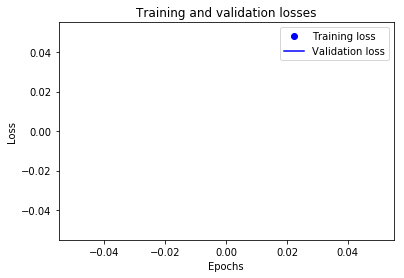

In [70]:
DoThiTiLeLoi(MoHinhTrainSig3)

In [71]:
modelSig4 = modelSig
Adad = optimizers.Adadelta(lr=0.01, rho=0.95, epsilon=None, decay=0.9)
modelSig4.compile(optimizer=Adad, loss=losses.mean_squared_error,metrics=[metrics.categorical_accuracy])
MoHinhTrainSig4 = modelSig4.fit(x_train, y_train, batch_size=batch_size, epochs=epoch, verbose=1, validation_data=(x_test, y_test))

Train on 35133 samples, validate on 11804 samples
Epoch 1/20
35133/35133 [==============================] - 37s 1ms/step - loss: nan - categorical_accuracy: 0.0140 - val_loss: nan - val_categorical_accuracy: 0.0139
Epoch 2/20
35133/35133 [==============================] - 35s 1ms/step - loss: nan - categorical_accuracy: 0.0140 - val_loss: nan - val_categorical_accuracy: 0.0139
Epoch 3/20
35133/35133 [==============================] - 35s 987us/step - loss: nan - categorical_accuracy: 0.0140 - val_loss: nan - val_categorical_accuracy: 0.0139
Epoch 4/20
35133/35133 [==============================] - 35s 987us/step - loss: nan - categorical_accuracy: 0.0140 - val_loss: nan - val_categorical_accuracy: 0.0139
Epoch 5/20
35133/35133 [==============================] - 35s 985us/step - loss: nan - categorical_accuracy: 0.0140 - val_loss: nan - val_categorical_accuracy: 0.0139
Epoch 6/20
35133/35133 [==============================] - 35s 988us/step - loss: nan - categorical_accuracy: 0.0140 - v

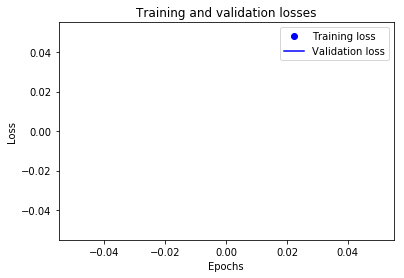

In [72]:
DoThiTiLeLoi(MoHinhTrainSig4)

In [73]:
modelSig5 = modelSig
adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.9, amsgrad=False)
modelSig5.compile(optimizer=adam, loss=losses.mean_squared_error,metrics=[metrics.categorical_accuracy])
MoHinhTrainSig5 = modelSig5.fit(x_train, y_train, batch_size=batch_size, epochs=epoch, verbose=1, validation_data=(x_test, y_test))

Train on 35133 samples, validate on 11804 samples
Epoch 1/20
35133/35133 [==============================] - 43s 1ms/step - loss: nan - categorical_accuracy: 0.0140 - val_loss: nan - val_categorical_accuracy: 0.0139
Epoch 2/20
35133/35133 [==============================] - 41s 1ms/step - loss: nan - categorical_accuracy: 0.0140 - val_loss: nan - val_categorical_accuracy: 0.0139
Epoch 3/20
35133/35133 [==============================] - 41s 1ms/step - loss: nan - categorical_accuracy: 0.0140 - val_loss: nan - val_categorical_accuracy: 0.0139
Epoch 4/20
35133/35133 [==============================] - 40s 1ms/step - loss: nan - categorical_accuracy: 0.0140 - val_loss: nan - val_categorical_accuracy: 0.0139
Epoch 5/20
35133/35133 [==============================] - 41s 1ms/step - loss: nan - categorical_accuracy: 0.0140 - val_loss: nan - val_categorical_accuracy: 0.0139
Epoch 6/20
35133/35133 [==============================] - 40s 1ms/step - loss: nan - categorical_accuracy: 0.0140 - val_loss:

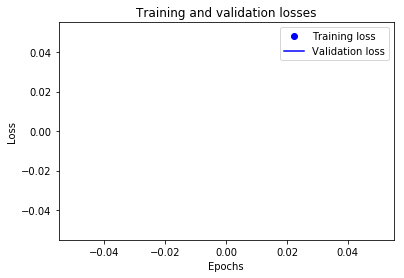

In [74]:
DoThiTiLeLoi(MoHinhTrainSig5)

# b. Thay đổi Layer mạng CNN

In [75]:
ChangeFiltermodel = Sequential()
ChangeFiltermodel.add(Conv2D(32, (5, 5), padding='same', activation='relu', input_shape=input_shape))
ChangeFiltermodel.add(Conv2D(32, (5, 5), activation='relu'))
ChangeFiltermodel.add(MaxPooling2D(pool_size=(2, 2)))
ChangeFiltermodel.add(Dropout(droprate))
 
ChangeFiltermodel.add(Conv2D(64, (5, 5), padding='same', activation='relu'))
ChangeFiltermodel.add(Conv2D(64, (5, 5), activation='relu'))
ChangeFiltermodel.add(MaxPooling2D(pool_size=(2, 2)))
ChangeFiltermodel.add(Dropout(droprate))
 
ChangeFiltermodel.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
ChangeFiltermodel.add(Conv2D(64, (3, 3), activation='relu'))
ChangeFiltermodel.add(MaxPooling2D(pool_size=(2, 2)))
ChangeFiltermodel.add(Dropout(droprate))
 
ChangeFiltermodel.add(Flatten())
ChangeFiltermodel.add(Dense(128, activation='relu'))
ChangeFiltermodel.add(Dropout(droprate))
ChangeFiltermodel.add(Dense(70, activation='softmax'))

In [76]:
ChangeFiltermodel1 = ChangeFiltermodel

In [77]:
ChangeFiltermodel1.compile(optimizer=optimizers.RMSprop(), loss=losses.categorical_crossentropy,metrics=[metrics.categorical_accuracy])

In [78]:
MoHinhChangeFiltermodel1 = ChangeFiltermodel1.fit(x_train, y_train, batch_size=batch_size, epochs=epoch, verbose=1, validation_data=(x_test, y_test))

Train on 35133 samples, validate on 11804 samples
Epoch 1/20
35133/35133 [==============================] - 81s 2ms/step - loss: 2.0848 - categorical_accuracy: 0.4492 - val_loss: 0.6328 - val_categorical_accuracy: 0.8168
Epoch 2/20
35133/35133 [==============================] - 76s 2ms/step - loss: 0.4030 - categorical_accuracy: 0.8737 - val_loss: 0.3726 - val_categorical_accuracy: 0.8822
Epoch 3/20
35133/35133 [==============================] - 62s 2ms/step - loss: 0.2007 - categorical_accuracy: 0.9394 - val_loss: 0.2764 - val_categorical_accuracy: 0.9133
Epoch 4/20
35133/35133 [==============================] - 52s 1ms/step - loss: 0.1283 - categorical_accuracy: 0.9605 - val_loss: 0.6358 - val_categorical_accuracy: 0.8562
Epoch 5/20
35133/35133 [==============================] - 58s 2ms/step - loss: 0.1080 - categorical_accuracy: 0.9664 - val_loss: 0.2196 - val_categorical_accuracy: 0.9319
Epoch 6/20
35133/35133 [==============================] - 63s 2ms/step - loss: 0.0926 - categor

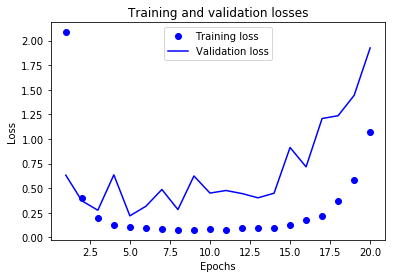

In [79]:
DoThiTiLeLoi(MoHinhChangeFiltermodel1)

In [80]:
ChangeFiltermodel2 = ChangeFiltermodel

In [81]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
ChangeFiltermodel2.compile(optimizer=sgd, loss=losses.mean_squared_error,metrics=[metrics.categorical_accuracy])
MoHinhChangeFiltermodel2 = ChangeFiltermodel2.fit(x_train, y_train, batch_size=batch_size, epochs=epoch, verbose=1, validation_data=(x_test, y_test))

Train on 35133 samples, validate on 11804 samples
Epoch 1/20
35133/35133 [==============================] - 183s 5ms/step - loss: 0.0016 - categorical_accuracy: 0.9429 - val_loss: 0.0035 - val_categorical_accuracy: 0.8778
Epoch 2/20
35133/35133 [==============================] - 148s 4ms/step - loss: 0.0012 - categorical_accuracy: 0.9558 - val_loss: 0.0031 - val_categorical_accuracy: 0.8905
Epoch 3/20
35133/35133 [==============================] - 170s 5ms/step - loss: 0.0011 - categorical_accuracy: 0.9615 - val_loss: 0.0031 - val_categorical_accuracy: 0.8891
Epoch 4/20
35133/35133 [==============================] - 143s 4ms/step - loss: 0.0010 - categorical_accuracy: 0.9633 - val_loss: 0.0029 - val_categorical_accuracy: 0.8983
Epoch 5/20
35133/35133 [==============================] - 196s 6ms/step - loss: 8.9144e-04 - categorical_accuracy: 0.9671 - val_loss: 0.0029 - val_categorical_accuracy: 0.8967
Epoch 6/20
35133/35133 [==============================] - 246s 7ms/step - loss: 8.0865

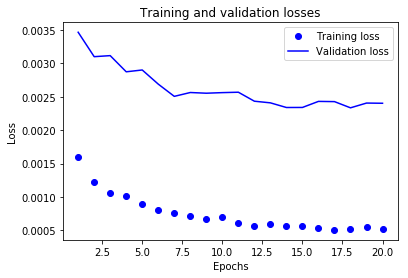

In [ ]:
DoThiTiLeLoi(MoHinhChangeFiltermodel2)

In [ ]:
ChangeFiltermodel5 = ChangeFiltermodel
adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.9, amsgrad=False)
ChangeFiltermodel5.compile(optimizer=adam, loss=losses.mean_squared_error,metrics=[metrics.categorical_accuracy])
MoHinhChangeFiltermodel5 = ChangeFiltermodel5.fit(x_train, y_train, batch_size=batch_size, epochs=epoch, verbose=1, validation_data=(x_test, y_test))

Train on 35133 samples, validate on 11804 samples
Epoch 1/20
35133/35133 [==============================] - 604s 17ms/step - loss: 8.4054e-04 - categorical_accuracy: 0.9702 - val_loss: 0.0022 - val_categorical_accuracy: 0.9221
Epoch 2/20
35133/35133 [==============================] - 680s 19ms/step - loss: 6.0696e-04 - categorical_accuracy: 0.9785 - val_loss: 0.0021 - val_categorical_accuracy: 0.9269
Epoch 3/20
35133/35133 [==============================] - 656s 19ms/step - loss: 5.4325e-04 - categorical_accuracy: 0.9805 - val_loss: 0.0021 - val_categorical_accuracy: 0.9255
Epoch 4/20
35133/35133 [==============================] - 729s 21ms/step - loss: 5.1728e-04 - categorical_accuracy: 0.9816 - val_loss: 0.0021 - val_categorical_accuracy: 0.9260
Epoch 5/20
35133/35133 [==============================] - 810s 23ms/step - loss: 4.9448e-04 - categorical_accuracy: 0.9823 - val_loss: 0.0021 - val_categorical_accuracy: 0.9259
Epoch 6/20
35133/35133 [==============================] - 848s 24